In [1]:
import math

In [2]:
import pipe_pytools.polar_plot as pp
import pipe_pytools.tools as tl
import pipe_pytools.grid as gr

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
cf,Xmax,epsr,lx,Jm,lt,nsym,VEL = tl.get_bcp("xmean.bcp")

In [5]:
cf

0.78

In [6]:
t,dt,Dp,Re,Xmax,epsr,lx,Jm,lt,nsym,vel = tl.get_scp("lin0.scp")

In [7]:
vel /= (vel.max() * 21)

In [23]:
vell_tmp = vel
vel = np.zeros_like(vel)

vel.T[1:16] = vell_tmp.T[-16:-1]
vel.T[16:-1] = vell_tmp.T[1:-16]

del vell_tmp

In [24]:
x = gr.X(2**lx, Xmax)
r = gr.R(Jm, epsr)
th = gr.Th(2**lt, nsym)

In [25]:
Im = x.m
hx = x.h
yt = r.f
yt1 = r.f1
rt = r.n
rt1 = r.n1
Km = th.m
ht = th.h

In [26]:
def bc(vel):
    u,v,w = vel
        
    vel[:,:,:,0] = vel[:,:,:,-2]
    vel[:,:,:,-1] = vel[:,:,:,1]
    
    for i in range(0,Im+1):
        for j in range(1,Jm+1):
            u.T[i,j,0] = u.T[i,j,1]
            u.T[i,j,Km+1] = u.T[i,j,Km]
            
        for k in range(1,Km+1):
            u.T[i,Jm+1,k] = - u.T[i,Jm,k]
            
    for k in range(1,Km+1):
        for i in range(1,Im+1):
            v.T[i,Jm,k] = 0.0
            
    for j in range(1,Jm+1):
        for i in range(1,Im+1):
            v.T[i,j,0] = v.T[i,j,1]
            v.T[i,j,Km+1] = v.T[i,j,Km]
            
    for j in range(1,Jm+1):
        for i in range(0,Im+2):
            w.T[i,j,0] = 0.0
            w.T[i,j,Km] = 0.0
            
    for k in range(0,Km+1):
        for i in range(1,Im+1):
            w.T[i,Jm+1,k] = - w.T[i,Jm,k] * yt[Jm] / yt[Jm+1]
            
    return vel

In [27]:
def rot(vel):
    bc(vel)
    u,v,w = vel
    
    om = np.zeros((3,Km+2,Jm+2,Im+2))
    ox,on,ot = om
    
    for i in range(1,Im+1):
        for j in range(1,Jm+1):
            for k in range(0,Km+1):
                w0 = w.T[i,j,k]
                w1 = w.T[i,j+1,k]
                v0 = v.T[i,j,k]
                v1 = v.T[i,j,k+1]
                ox.T[i,j,k] = ((yt[j+1]*w1 - yt[j]*w0) / rt1[j] - (v1 - v0) / ht) / rt[j]
                
        for j in range(0,1):
            for k in range(0,Km+1):
                ox.T[i,j,k] = 0.0
                
    for k in range(0,Km+1):
        for j in range(1,Jm+1):
            for i in range(0,Im+1):
                u0 = u.T[i,j,k]
                u1 = u.T[i,j,k+1]
                w0 = w.T[i,j,k]
                w1 = w.T[i+1,j,k]
                on.T[i,j,k] = (u1 - u0) / (yt[j] * ht) - (w1 - w0) / hx
                
    for k in range(1,Km+1):
        for j in range(1,Jm+1):
            for i in range(0,Im+1):
                u0 = u.T[i,j,k]
                u1 = u.T[i,j+1,k]
                v0 = v.T[i,j,k]
                v1 = v.T[i+1,j,k]
                ot.T[i,j,k] = (v1 - v0) / hx - (u1 - u0) / rt1[j]
    
    return om

In [28]:
def nonlin(vel,om):
    u,v,w = vel
    ox,on,ot = om
    velt = np.zeros((3,Km+2,Jm+2,Im+2))
    ut,vt,wt = velt
    
    for i in range(1,Im+1):
        for j in range(1,Jm+1):
            for k in range(1,Km+1):
                v0 = 0.5 * (v.T[i,j-1,k] + v.T[i+1,j-1,k])
                v1 = 0.5 * (v.T[i,j,k] + v.T[i+1,j,k])
                ot0 = rt[j-1] * rt1[j-1] * ot.T[i,j-1,k]
                ot1 = rt[j] * rt1[j] * ot.T[i,j,k]
                w0 = 0.5 * (w.T[i,j,k-1] + w.T[i+1,j,k-1])
                w1 = 0.5 * (w.T[i,j,k] + w.T[i+1,j,k])
                or0 = on.T[i,j,k-1]
                or1 = on.T[i,j,k]
                ut.T[i,j,k] = 0.5 * ((v0*ot0 + v1*ot1) / (yt[j] * yt1[j]) - (w0*or0 + w1*or1))
        
    for k in range(1,Km+1):
        for i in range(1,Im+1):
            for j in range(1,Jm):
                w0 = 0.5 * (w.T[i,j,k-1] + w.T[i,j+1,k-1])
                w1 = 0.5 * (w.T[i,j,k] + w.T[i,j+1,k])
                ox0 = ox.T[i,j,k-1]
                ox1 = ox.T[i,j,k]
                u0 = 0.5 * (u.T[i-1,j,k] + u.T[i-1,j+1,k])
                u1 = 0.5 * (u.T[i,j,k] + u.T[i,j+1,k])
                ot0 = ot.T[i-1,j,k]
                ot1 = ot.T[i,j,k]
                vt.T[i,j,k] = 0.5 * ((w0*ox0 + w1*ox1) - (u0*ot0 + u1*ot1))
        
            vt.T[i,Jm,k] = 0.0
            
    for k in range(1,Km+1):
        for j in range(1,Jm+1):
            for i in range(1,Im+1):
                u0 = 0.5 * (u.T[i-1,j,k] + u.T[i-1,j,k+1])
                u1 = 0.5 * (u.T[i,j,k] + u.T[i,j,k+1])
                or0 = on.T[i-1,j,k]
                or1 = on.T[i,j,k]
                v0 = 0.5 * (v.T[i,j-1,k] + v.T[i,j-1,k+1])
                v1 = 0.5 * (v.T[i,j,k] + v.T[i,j,k+1])
                ox0 = rt[j-1] * rt1[j-1] * ox.T[i,j-1,k]
                ox1 = rt[j] * rt1[j] * ox.T[i,j,k]
                wt.T[i,j,k] = 0.5 * ((u0*or0 + u1*or1) - (v0*ox0 + v1*ox1) / (yt[j] * yt1[j]))
                
    return velt

In [29]:
def get_nl_part(vel,om):
    u,v,w = vel
    ox,on,ot = om
    
    vt1 = np.zeros((Km+2,Jm+2,Im+2))
    vt2 = np.zeros((Km+2,Jm+2,Im+2))
    wt1 = np.zeros((Km+2,Jm+2,Im+2))
    wt2 = np.zeros((Km+2,Jm+2,Im+2))
       
    for k in range(1,Km+1):
        for i in range(1,Im+1):
            for j in range(1,Jm):
                w0 = 0.5 * (w.T[i,j,k-1] + w.T[i,j+1,k-1])
                w1 = 0.5 * (w.T[i,j,k] + w.T[i,j+1,k])
                ox0 = ox.T[i,j,k-1]
                ox1 = ox.T[i,j,k]
                u0 = 0.5 * (u.T[i-1,j,k] + u.T[i-1,j+1,k])
                u1 = 0.5 * (u.T[i,j,k] + u.T[i,j+1,k])
                ot0 = ot.T[i-1,j,k]
                ot1 = ot.T[i,j,k]
                vt1.T[i,j,k] = 0.5 * ( - (u0*ot0 + u1*ot1))
                vt2.T[i,j,k] = 0.5 * ((w0*ox0 + w1*ox1))
        
            vt1.T[i,Jm,k] = 0.0
            vt2.T[i,Jm,k] = 0.0
            
    for k in range(1,Km+1):
        for j in range(1,Jm+1):
            for i in range(1,Im+1):
                u0 = 0.5 * (u.T[i-1,j,k] + u.T[i-1,j,k+1])
                u1 = 0.5 * (u.T[i,j,k] + u.T[i,j,k+1])
                or0 = on.T[i-1,j,k]
                or1 = on.T[i,j,k]
                v0 = 0.5 * (v.T[i,j-1,k] + v.T[i,j-1,k+1])
                v1 = 0.5 * (v.T[i,j,k] + v.T[i,j,k+1])
                ox0 = rt[j-1] * rt1[j-1] * ox.T[i,j-1,k]
                ox1 = rt[j] * rt1[j] * ox.T[i,j,k]
                wt1.T[i,j,k] = 0.5 * ((u0*or0 + u1*or1))
                wt2.T[i,j,k] = 0.5 * ( - (v0*ox0 + v1*ox1) / (yt[j] * yt1[j]))
                
    return vt1, vt2, wt1, wt2

In [30]:
def get_ox(v,w):
    ox = np.zeros((Km+2,Jm+2,Im+2))
    
    for i in range(1,Im+1):
        for j in range(1,Jm+1):
            for k in range(0,Km+1):
                w0 = w.T[i,j,k]
                w1 = w.T[i,j+1,k]
                v0 = v.T[i,j,k]
                v1 = v.T[i,j,k+1]
                ox.T[i,j,k] = ((yt[j+1]*w1 - yt[j]*w0) / rt1[j] - (v1 - v0) / ht) / rt[j]
                
        for j in range(0,1):
            for k in range(0,Km+1):
                ox.T[i,j,k] = 0.0
                
    return ox

In [31]:
om = rot(vel)

In [32]:
u,v,w = vel
ox,on,ot = om

In [33]:
vt1, vt2, wt1, wt2 = get_nl_part(vel,om)

In [34]:
ox1 = get_ox(vt1,wt1)

In [35]:
ox2 = get_ox(vt2,wt2)

In [36]:
oxs = rot(nonlin(vel,om))[0]

In [37]:
(ox1 + ox2 - oxs)[1:-2,1:-2,1:-1].max()

9.5192950744227289e-17

In [38]:
ut = np.zeros_like(u)

for k in range(1,Km+1):
    for j in range(1,Jm+1):
        for i in range(1,Im+1):
            ut[k,j,i] = (u[k+1,j,i] - u[k,j,i]) / (rt[j] * ht)

In [39]:
d3x = ot*ut

In [40]:
ur = np.zeros_like(u)

for k in range(1,Km+1):
    for j in range(1,Jm+1):
        for i in range(1,Im+1):
            ur[k,j,i] = (u[k,j+1,i] - u[k,j,i]) / rt1[j]

In [41]:
d2x = on*ur

In [42]:
oxx = np.zeros_like(ox)
ox.T[0] = ox.T[-2]
ox.T[-1] = ox.T[1]
for k in range(1,Km+1):
    for j in range(1,Jm+1):
        for i in range(1,Im+1):
            oxx[k,j,i] = (ox[k,j,i+1] - ox[k,j,i]) / hx

In [43]:
cux = -u*oxx

In [44]:
vx = np.zeros_like(v)

for k in range(1,Km+1):
    for j in range(1,Jm+1):
        for i in range(1,Im+1):
            vx[k,j,i] = (v[k,j,i+1] - v[k,j,i]) / hx

In [45]:
wx = np.zeros_like(w)

for k in range(1,Km+1):
    for j in range(1,Jm+1):
        for i in range(1,Im+1):
            wx[k,j,i] = (w[k,j,i+1] - w[k,j,i]) / hx

In [46]:
d23x = vx*ut - ur*wx

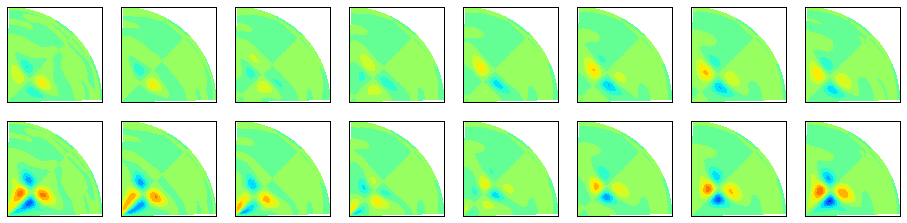

In [76]:
plt.figure(figsize=(16,16))
n = 1

for ii in range(1,33,4):
    plt.subplot(8,8,n)
    pp.polar_contourf(yt[1:-1], th.f[1:-1], d23x[1:-1,1:-1,ii], (-0.006,0.006))
    n+=1

for ii in range(1,33,4):
    plt.subplot(8,8,n)
    pp.polar_contourf(yt[1:-1], th.f[1:-1], (d2x+d3x)[1:-1,1:-1,ii], (-0.006,0.006))
    n+=1

In [48]:
nl1 = cux + d23x

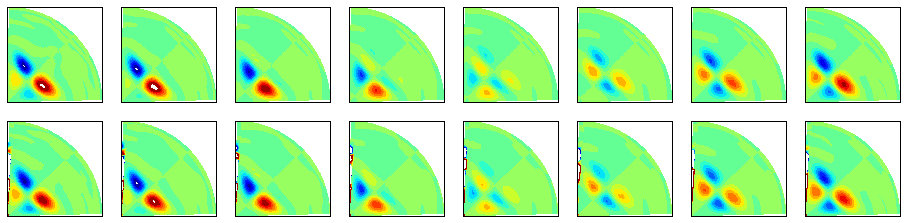

In [49]:
plt.figure(figsize=(16,16))
n = 1

for ii in range(1,33,4):
    plt.subplot(8,8,n)
    pp.polar_contourf(yt[1:-1], th.f[1:-1], nl1[1:-1,1:-1,ii], (-0.006,0.006))
    n+=1

for ii in range(1,33,4):
    plt.subplot(8,8,n)
    pp.polar_contourf(yt[1:-1], th.f[1:-1], ox1[1:-1,1:-1,ii], (-0.006,0.006))
    n+=1

In [77]:
ux = np.zeros_like(u)
u.T[0] = u.T[-2]
u.T[-1] = u.T[1]
for k in range(1,Km+1):
    for j in range(1,Jm+1):
        for i in range(1,Im+1):
            ux[k,j,i] = (u[k,j,i+1] - u[k,j,i]) / hx

In [78]:
d1x = ox*ux

In [79]:
oxr = np.zeros_like(ox)

for k in range(1,Km+1):
    for j in range(1,Jm+1):
        for i in range(1,Im+1):
            oxr[k,j,i] = (ox[k,j+1,i] - ox[k,j,i]) / rt1[j]

In [80]:
cvx = -v*oxr

In [81]:
oxt = np.zeros_like(ox)

for k in range(1,Km+1):
    for j in range(1,Jm+1):
        for i in range(1,Im+1):
            oxt[k,j,i] = (ox[k+1,j,i] - ox[k,j,i]) / (rt[j] * ht)

In [82]:
cwx = -w*oxt

In [83]:
nl2 = cvx + cwx + d1x

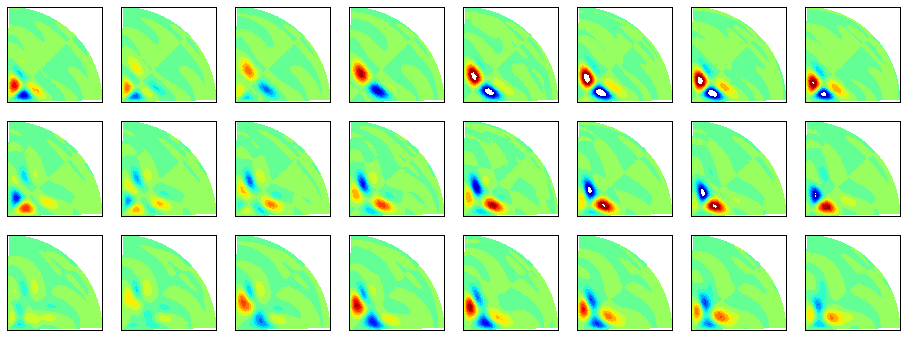

In [84]:
plt.figure(figsize=(16,16))
n = 1

for ii in range(1,33,4):
    plt.subplot(8,8,n)
    pp.polar_contourf(yt[1:-1], th.f[1:-1], cvx[1:-1,1:-1,ii], (-0.006,0.006))
    n+=1

for ii in range(1,33,4):
    plt.subplot(8,8,n)
    pp.polar_contourf(yt[1:-1], th.f[1:-1], cwx[1:-1,1:-1,ii], (-0.006,0.006))
    n+=1

for ii in range(3,33,4):
    plt.subplot(8,8,n)
    pp.polar_contourf(yt[1:-1], th.f[1:-1], (cvx+cwx)[1:-1,1:-1,ii], (-0.006,0.006))
    n+=1

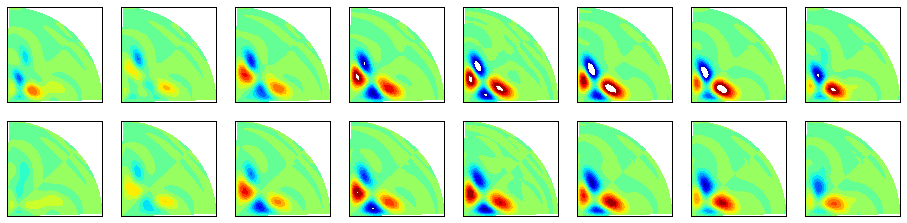

In [85]:
plt.figure(figsize=(16,16))
n = 1

for ii in range(1,33,4):
    plt.subplot(8,8,n)
    pp.polar_contourf(yt[1:-1], th.f[1:-1], nl2[1:-1,1:-1,ii], (-0.006,0.006))
    n+=1

for ii in range(1,33,4):
    plt.subplot(8,8,n)
    pp.polar_contourf(yt[1:-1], th.f[1:-1], ox2[1:-1,1:-1,ii], (-0.006,0.006))
    n+=1


In [86]:
(nl2-ox2)[2:-2,2:-2,2:-2].max() / (nl2+ox2)[2:-2,2:-2,2:-2].max()

0.20158906347945907

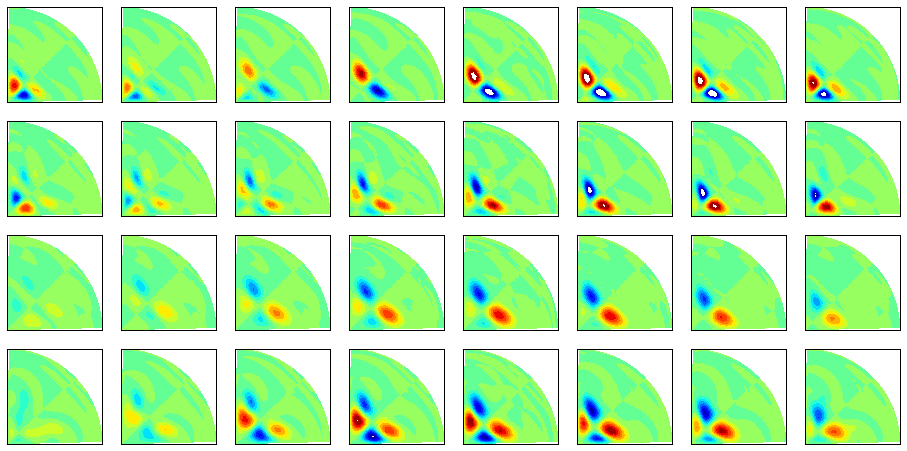

In [87]:
plt.figure(figsize=(16,16))
n = 1

for ii in range(1,33,4):
    plt.subplot(8,8,n)
    pp.polar_contourf(yt[1:-1], th.f[1:-1], cvx[1:-1,1:-1,ii], (-0.006,0.006))
    n+=1

for ii in range(1,33,4):
    plt.subplot(8,8,n)
    pp.polar_contourf(yt[1:-1], th.f[1:-1], cwx[1:-1,1:-1,ii], (-0.006,0.006))
    n+=1

for ii in range(1,33,4):
    plt.subplot(8,8,n)
    pp.polar_contourf(yt[1:-1], th.f[1:-1], d1x[1:-1,1:-1,ii], (-0.006,0.006))
    n+=1
    
for ii in range(1,33,4):
    plt.subplot(8,8,n)
    pp.polar_contourf(yt[1:-1], th.f[1:-1], ox2[1:-1,1:-1,ii], (-0.006,0.006))
    n+=1

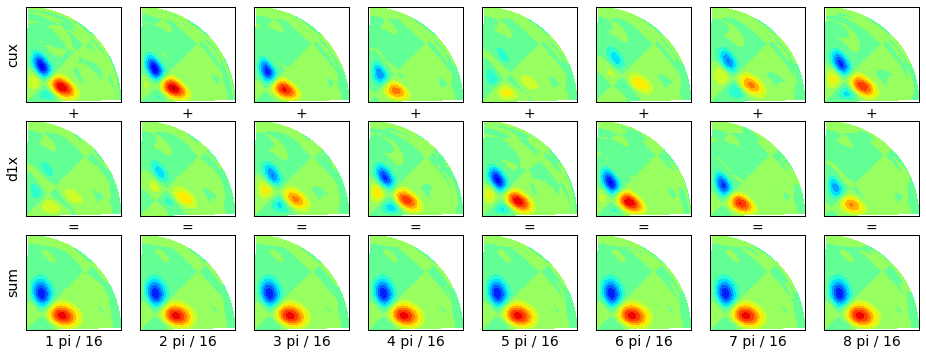

In [88]:
plt.figure(figsize=(16,16))
n = 1

for ii in range(1,33,4):
    plt.subplot(8,8,n)
    pp.polar_contourf(yt[1:-1], th.f[1:-1], cux[1:-1,1:-1,ii], (-0.006,0.006))
    if n%8==1:
        plt.ylabel("cux", fontsize=14)
    plt.xlabel("+", fontsize=14)
    n+=1
    
for ii in range(1,33,4):    
    plt.subplot(8,8,n)
    pp.polar_contourf(yt[1:-1], th.f[1:-1], d1x[1:-1,1:-1,ii], (-0.006,0.006))
    if n%8==1:
        plt.ylabel("d1x", fontsize=14)
    plt.xlabel("=", fontsize=14)
    n+=1
    
for ii in range(1,33,4):
    plt.subplot(8,8,n)
    pp.polar_contourf(yt[1:-1], th.f[1:-1], (d1x+cux)[1:-1,1:-1,ii], (-0.006,0.006))
    if n%8==1:
        plt.ylabel("sum", fontsize=14)
    plt.xlabel("%d pi / 16" % (n-16), fontsize=14)
    n+=1
    

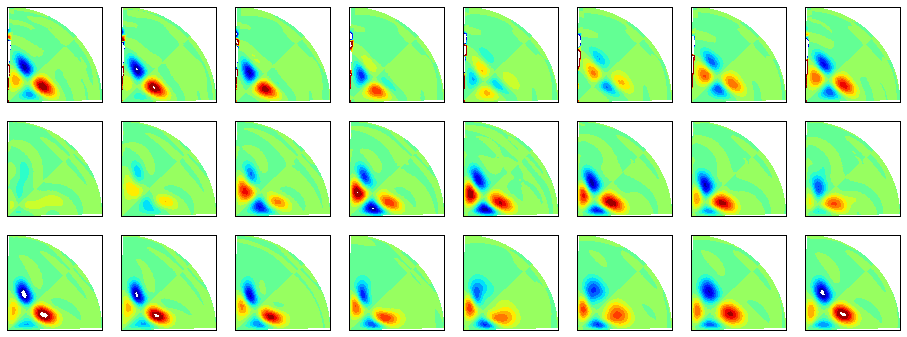

In [89]:
plt.figure(figsize=(16,16))
n = 1

for ii in range(1,33,4):
    plt.subplot(8,8,n)
    pp.polar_contourf(yt[1:-1], th.f[1:-1], ox1[1:-1,1:-1,ii], (-0.006,0.006))
    n+=1
    
for ii in range(1,33,4):  
    plt.subplot(8,8,n)
    pp.polar_contourf(yt[1:-1], th.f[1:-1], ox2[1:-1,1:-1,ii], (-0.006,0.006))
    n+=1
    
for ii in range(1,33,4):
    plt.subplot(8,8,n)
    pp.polar_contourf(yt[1:-1], th.f[1:-1], oxs[1:-1,1:-1,ii], (-0.006,0.006))
    n+=1

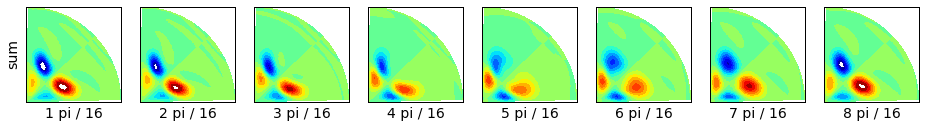

In [90]:
plt.figure(figsize=(16,16))
n = 1
ff = True
for ii in range(1,33,4):
    plt.subplot(8,8,n)
    pp.polar_contourf(yt[1:-1], th.f[1:-1], oxs[1:-1,1:-1,ii], (-0.006,0.006))
    plt.xlabel("%d pi / 16" % n, fontsize=14)
    if ff:
        ff = False
        plt.ylabel("sum", fontsize=14)
    n+=1


In [92]:
ctx = cvx+cwx

In [93]:
ctx_puls = (((ctx.T - ctx.T[1:-1].mean(0))**2)[1:-1].mean(0)**0.5).T

In [94]:
np.array(ctx_puls).max()

0.0027412582788673705

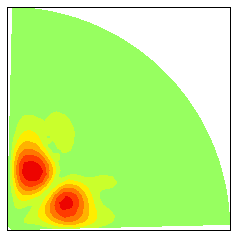

In [98]:
pp.polar_contourf(yt[1:-1], th.f[1:-1], ctx_puls[1:-1,1:-1], (-0.003,0.003))

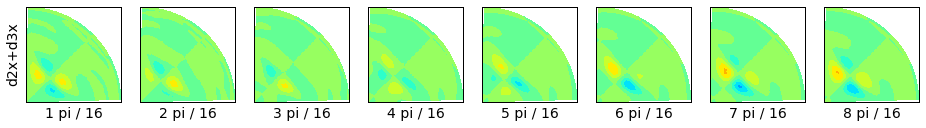

In [288]:
plt.figure(figsize=(16,16))
n = 1
ff = True
for ii in range(1,33,4):
    plt.subplot(8,8,n)
    pp.polar_contourf(yt[1:-1], th.f[1:-1], d23x[1:-1,1:-1,ii], (-0.006,0.006))
    plt.xlabel("%d pi / 16" % (n), fontsize=14)
    if ff:
        ff = False
        plt.ylabel("d2x+d3x", fontsize=14)
    n+=1